# Helmholtz 1D - AutoAMG on a Fixed Domain Size

## Goal
Given the Helhmholtz operator $A = -\Delta + k^2 I$ discretized with a $5$-point 4$th$ order finite stencil, find **test functions** $x$ of unit $l_2$ norm with small $\|A x\|$; i.e., near-null-space components, on a periodic domain, with constant $k$. Then observe 


## Discretization
We use the 3-point finite difference $A^h = [1, -2 + (kh)^2, 1]$. In this experiment we use a fixed periodic domain with $n=16$ points and a small $kh=0.5$. The final grid on the large domain will have a much smaller $kh$ to yield a good discretization, but as we coarsen it $kh$ increases, so this simulates the level where we already see waves (2 coarse variables per aggregate).

In [167]:
import logging
import numpy as np
import helmholtz as hm
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics.pairwise
import sys
from numpy.ma.testutils import assert_array_almost_equal
from scipy.linalg import eig, norm
from scipy.sparse.linalg import eigs

import helmholtz as hm
import helmholtz.setup.hierarchy as hierarchy

%load_ext autoreload
%autoreload 2

np.set_printoptions(linewidth=500, precision=5, suppress=False)
for handler in logging.root.handlers[:]: logging.root.removeHandler(handler)
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format="%(levelname)-8s %(message)s",
                    datefmt="%a, %d %b %Y %H:%M:%S")

logger = logging.getLogger("main")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [169]:
n = 96
kh = 0.5
num_examples = 20
max_levels = 2
num_bootstrap_cycles = 3

# Initialize test functions (to random) and hierarchy at coarsest level.
a = hm.linalg.helmholtz_1d_5_point_operator(kh, n).tocsr()
level = hierarchy.create_finest_level(a)
multilevel = hm.hierarchy.multilevel.Multilevel(level)
x = hm.solve.run.random_test_matrix((a.shape[0],), num_examples=num_examples)

x_all = [None] * (num_bootstrap_cycles + 1)
i = 0
x_all[i] = x
logger.info("RER {:.2f}".format(norm(a.dot(x)) / norm(x)))

# Relax vector + coarsen in first iteration; then 2-level cycle + improve hierarchy (bootstrap).
for i in range(1, num_bootstrap_cycles + 1):
    x, multilevel = hm.setup.auto_setup.bootstap(x, multilevel, max_levels, num_sweeps=10)
    x_all[i] = x

    # Test two-level cycle convergence for A*x=0.
    two_level_cycle = lambda x: hm.solve.solve_cycle.solve_cycle(multilevel, 1.0, 1, 1).run(x)
    x0 = np.random.random((a.shape[0], ))
    y, conv_factor = hm.solve.run.run_iterative_method(level.operator, two_level_cycle, x0, 20)
    logger.info("RER {:.2f} 2-level conv factor {:.2f}".format(
        norm(a.dot(x)) / norm(x), conv_factor))

INFO     RER 2.91
INFO     Coarsening level 0->1
INFO     P error: fit 0.260 val 0.159 test 0.049 alpha mean 0.015
INFO     RER 0.16 2-level conv factor 0.43
INFO     Coarsening level 0->1
INFO     P error: fit 0.021 val 0.026 test 0.008 alpha mean 0.000
INFO     RER 0.07 2-level conv factor 0.67
INFO     Coarsening level 0->1
INFO     P error: fit 0.006 val 0.022 test 0.003 alpha mean 0.000
INFO     RER 0.06 2-level conv factor 0.75


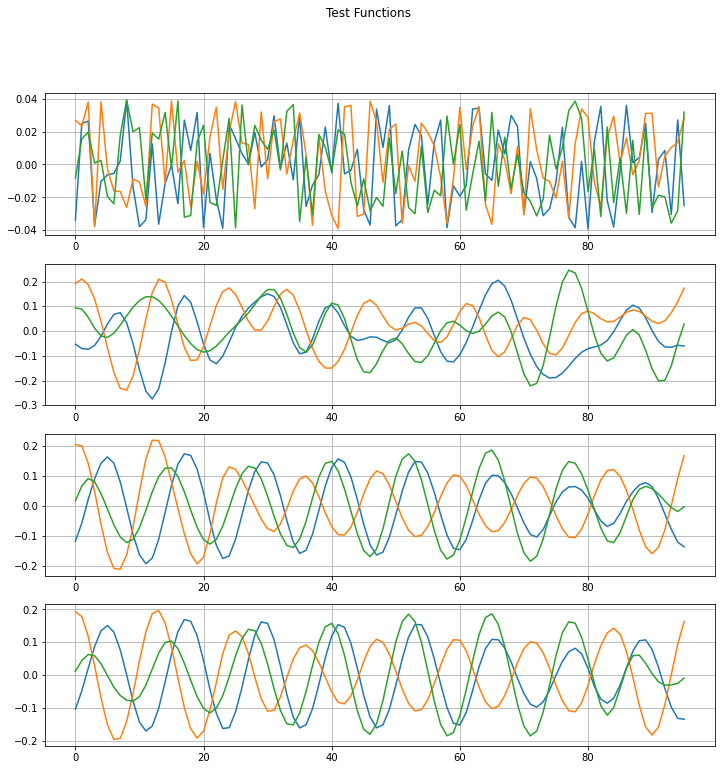

In [170]:
fig, axs = plt.subplots(len(x_all), 1, figsize=(12, 12))
fig.suptitle('Test Functions')
for i, x in enumerate(x_all):
    ax = axs[i]
    for j in range(3):
        ax.plot(x[:, j])
    ax.grid(True);

In [171]:
lam = [None] * len(multilevel)
v = [None] * len(multilevel)
for l in range(len(multilevel)):
    level = multilevel.level[l]
    lam[l], v[l] = eig(level.a.todense(), b=level.b.todense())
    lam[l] = np.real(lam[l])
    ind = np.argsort(np.abs(lam[l]))
    lam[l] = lam[l][ind]
    v[l] = v[l][ind]

(-0.1, 0.1)

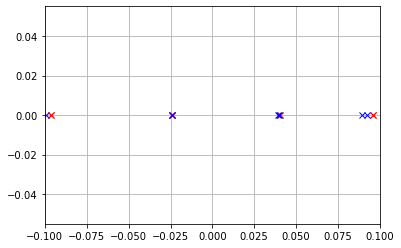

In [172]:
plt.plot(lam[0], np.zeros_like(lam[0]), 'rx')
plt.plot(lam[1], np.zeros_like(lam[1]), 'bx')
plt.grid(True)
plt.xlim([-0.1, 0.1])

In [173]:
k = 20
lf = lam[0][:k][:, None] 
lc = lam[1][:k][:, None]
pd.DataFrame(np.concatenate((lf, lc, np.abs(lc - lf)/np.abs(lf)), axis=1),
            columns=("lam0", "lam1", "rel error"))

,lam0,lam1,rel error
0,-0.023932,-0.024164,0.009686
1,-0.023932,-0.024269,0.014087
2,0.040200,0.038954,0.030998
3,0.040200,0.039764,0.010866
4,0.095828,0.089628,0.064694
5,0.095828,0.092177,0.038095
6,-0.096528,-0.099327,0.028993
7,-0.096528,-0.102428,0.061121
8,0.142921,0.126711,0.113420
9,0.142921,0.137368,0.038860


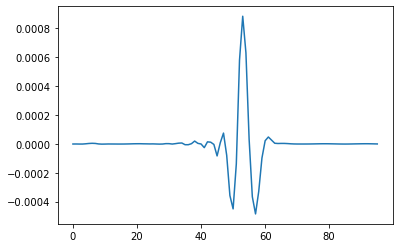

In [174]:
plt.plot(y)

In [177]:
coarse_level = multilevel.level[1]
p = coarse_level.p
r = coarse_level._restriction_csr
p.todense()

matrix([[ 0.2363 , -0.35419,  0.     , ...,  0.     ,  0.13663,  0.39793],
        [ 0.66692, -0.44801,  0.     , ...,  0.     , -0.0835 , -0.24298],
        [ 0.67617,  0.49797,  0.11876, ...,  0.     ,  0.     ,  0.     ],
        ...,
        [ 0.     ,  0.     ,  0.     , ...,  0.64003,  0.61928, -1.15434],
        [-0.07484,  0.09756,  0.     , ...,  0.     ,  0.62178,  0.33674],
        [ 0.07169, -0.14003,  0.     , ...,  0.     ,  0.43022,  0.4525 ]])

In [187]:
norm(p.dot(r.dot(y)) - y) / norm(y)

3.9649116244139533

In [192]:
p[53].todense()

matrix([[ 0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.1705 , -0.61228, -0.41599, -0.36783,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ]])